# 동행복권 회차별 로또 정보 요청 API

In [49]:
import requests
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class LottoCash:
    def __init__(self, host, port, db, user, passwd):
        self.host=host
        self.port=port
        self.db=db
        self.user=user
        self.passwd=passwd
        self.lotto_url = "https://www.dhlottery.co.kr/common.do?method=getLottoNumber&drwNo="
        self.drwNo = 0     ## 회차
        
    def db_conn(self):
        try:
            conn = pymysql.connect(host=self.host, port=self.port, db=self.db, user=self.user, passwd=self.passwd)
            return conn
        except Exception as e:
            print(e)
            
    def get_drwNo(self, conn):
        try:
#             mySql connect후 cursor를 활용하는 방식에서 pandas의 read_sql(DataFrame)활용으로 변경
#             cursor = conn.cursor()
#             cursor.execute("""SELECT drwNo FROM lotto LIMIT1 ORDER BY drwNo desc """)
#             df_result = pd.DataFrame(cursor.fetchall())
#             print("result = "+str(df_result[0][0]))
            sql = """select drwNo From lotto ORDER BY drwNo desc LIMIT 1"""
            df_result = pd.read_sql(sql, conn)
            df_result['drwNo'][0]

            if df_result.empty:
                self.drwNo = 1
            else:
                self.drwNo = df_result['drwNo'][0]+1
            print("수집할 회차 : "+str(self.drwNo))
        except Exception as e:
            conn.close()
            print(e)
            
    
    def get_lottoInfo(self, conn=None):
        if conn is not None:    # 회차별 로또 정보 가져오기 From DB(MySql)
            try:
                sql = """SELECT drwNo
                                , drwNoDate
                                , drwtNo1, drwtNo2, drwtNo3, drwtNo4, drwtNo5, drwtNo6, bnusNo
                                , firstAccumamnt
                                , firstPrzwnerCo
                                , firstWinamnt
                                , totSellamnt
                                , returnValue
                            FROM lotto"""
                result = pd.read_sql(sql, conn)
                return result
            except Exception as e:
                print(e)
        else:    # 회차별 로또 정보 가져오기 From API
            try:
                round_url = self.lotto_url+str(self.drwNo)    # 동행복권 로또API에 원하는 회차를 입력
                print(str(self.drwNo)+"회차 = "+round_url)
                result = requests.get(round_url)
                return result.json()
            except Exception as e:
                print(e)

    def set_lottoInfo(self, conn, round_lottoInfo):
        try:
            cursor = conn.cursor()
            sql = """INSERT INTO lotto (drwNo
                                        , drwNoDate
                                        , drwtNo1, drwtNo2, drwtNo3, drwtNo4, drwtNo5, drwtNo6, bnusNo
                                        , firstAccumamnt
                                        , firstPrzwnerCo
                                        , firstWinamnt
                                        , totSellamnt
                                        , returnValue) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
            datas = (round_lottoInfo.get('drwNo')
                    , round_lottoInfo.get('drwNoDate')
                    , round_lottoInfo.get('drwtNo1')
                    , round_lottoInfo.get('drwtNo2')
                    , round_lottoInfo.get('drwtNo3')
                    , round_lottoInfo.get('drwtNo4')
                    , round_lottoInfo.get('drwtNo5')
                    , round_lottoInfo.get('drwtNo6')
                    , round_lottoInfo.get('bnusNo')
                    , round_lottoInfo.get('firstAccumamnt')
                    , round_lottoInfo.get('firstPrzwnerCo')
                    , round_lottoInfo.get('firstWinamnt')
                    , round_lottoInfo.get('totSellamnt')
                    , round_lottoInfo.get('returnValue'))
            print(datas)
            cursor.execute(sql, datas)
            conn.commit()
        except Exception as e:
            conn.close()
            print(e)
        finally:
            cursor.close()

In [3]:
lotto = LottoCash('localhost', 3306, 'lotto', 'administrator', '12qwaszx!@')

## 수집할 회차 정보 조회

In [4]:
conn = lotto.db_conn()
lotto.get_drwNo(conn)

수집할 회차 : 999


## 데이터 수집 및 DB 적재

In [5]:
while True:
    round_lottoInfo = lotto.get_lottoInfo()
    if "fail"!=round_lottoInfo.get('returnValue'):
        lotto.set_lottoInfo(conn, round_lottoInfo)    
        lotto.drwNo = lotto.drwNo+1
    else:
        break
    

999회차 = https://www.dhlottery.co.kr/common.do?method=getLottoNumber&drwNo=999


In [6]:
# conn.close()

## 최다/최소 빈도 번호 구하기

In [7]:
lottoData = lotto.get_lottoInfo(conn)
lottoData

drwNo   drwNoDate  drwtNo1  drwtNo2  drwtNo3  drwtNo4  drwtNo5  drwtNo6  \
0        1  2002-12-07       10       23       29       33       37       40   
1        2  2002-12-14        9       13       21       25       32       42   
2        3  2002-12-21       11       16       19       21       27       31   
3        4  2002-12-28       14       27       30       31       40       42   
4        5  2003-01-04       16       24       29       40       41       42   
..     ...         ...      ...      ...      ...      ...      ...      ...   
993    994  2021-12-18        1        3        8       24       27       35   
994    995  2021-12-25        1        4       13       29       38       39   
995    996  2022-01-01        6       11       15       24       32       39   
996    997  2022-01-08        4        7       14       16       24       44   
997    998  2022-01-15       13       17       18       20       42       45   

     bnusNo  firstAccumamnt  firstPrzwnerCo  firstWinamnt   totSellamnt  \
0        16       863604600               0             0    3681782000   
1         2               0               1    2002006800    4904274000   
2        30               0               1    2000000000    4729342000   
3         2      1267147200               0             0    5271464000   
4         3      3041094900               0             0    6277102000   
..      ...             ...             ...           ...           ...   
993      28     22338984756              12    1861582063   95530936000   
994       7     24130903125               7    3447271875  100878455000   
995      28     26841343878              18    1491185771  112624327000   
996      20     23821241640              19    1253749560  102431961000   
997      41     24917995884              12    2076499657  101681869000   

    returnValue  
0       success  
1       success  
2       success  
3       success  
4       success  
..          ...  
993     success  
994     success  
995     success  
996     success  
997     success  

[998 rows x 14 columns]

In [8]:
numbers = lottoData[['drwtNo1', 'drwtNo2', 'drwtNo3', 'drwtNo4', 'drwtNo5', 'drwtNo6', 'bnusNo']]
numbers.T # 편하게 보기 위함..(취향)

0    1    2    3    4    5    6    7    8    9    ...  988  989  990  \
drwtNo1   10    9   11   14   16   14    2    8    2    9  ...   17    2   13   
drwtNo2   23   13   16   27   24   15    9   19    4   25  ...   18    4   18   
drwtNo3   29   21   19   30   29   26   16   25   16   30  ...   21   25   25   
drwtNo4   33   25   21   31   40   27   25   34   17   33  ...   27   26   31   
drwtNo5   37   32   27   40   41   40   26   37   36   41  ...   29   36   33   
drwtNo6   40   42   31   42   42   42   40   39   39   44  ...   33   37   44   
bnusNo    16    2   30    2    3   34   42    9   14    6  ...   26   28   38   

         991  992  993  994  995  996  997  
drwtNo1   12    6    1    1    6    4   13  
drwtNo2   20   14    3    4   11    7   17  
drwtNo3   26   16    8   13   15   14   18  
drwtNo4   33   18   24   29   24   16   20  
drwtNo5   44   24   27   38   32   24   42  
drwtNo6   45   42   35   39   39   44   45  
bnusNo    24   44   28    7   28   20   41  

[7 rows x 998 columns]

In [9]:
# 결측치 개수 확인
numbers.isnull().sum()

drwtNo1    0
drwtNo2    0
drwtNo3    0
drwtNo4    0
drwtNo5    0
drwtNo6    0
bnusNo     0
dtype: int64

In [10]:
listNo=numbers.values.tolist()
listNo_sum = sum(listNo, [])
df_listNo = pd.DataFrame(listNo_sum)
df_listNo.T

0     1     2     3     4     5     6     7     8     9     ...  6976  \
0    10    23    29    33    37    40    16     9    13    21  ...    24   

   6977  6978  6979  6980  6981  6982  6983  6984  6985  
0    44    20    13    17    18    20    42    45    41  

[1 rows x 6986 columns]

In [21]:
top6 = df_listNo.value_counts().head(6)
bottom6 = df_listNo.value_counts().tail(6)
print("빈도 수 상위 6개 = \n" + str(top6))
print("빈도 수 하위 6개 = \n" + str(bottom6))
print("빈도 수 상위 6개 = " + str([no[0] for no in top6.index]))
print("빈도 수 하위 6개 = " + str([no[0] for no in bottom6.index]))

빈도 수 상위 6개 = 
43    179
27    171
34    170
13    170
1     170
17    168
dtype: int64
빈도 수 하위 6개 = 
32    139
23    138
41    138
29    135
9     128
22    127
dtype: int64
빈도 수 상위 6개 = [43, 27, 34, 13, 1, 17]
빈도 수 하위 6개 = [32, 23, 41, 29, 9, 22]


In [13]:
# print([no[0] for no in df_listNo.value_counts().index])
# print(df_listNo.value_counts().values.tolist())
# max(df_listNo.value_counts().values.tolist())
# min(df_listNo.value_counts().values.tolist())

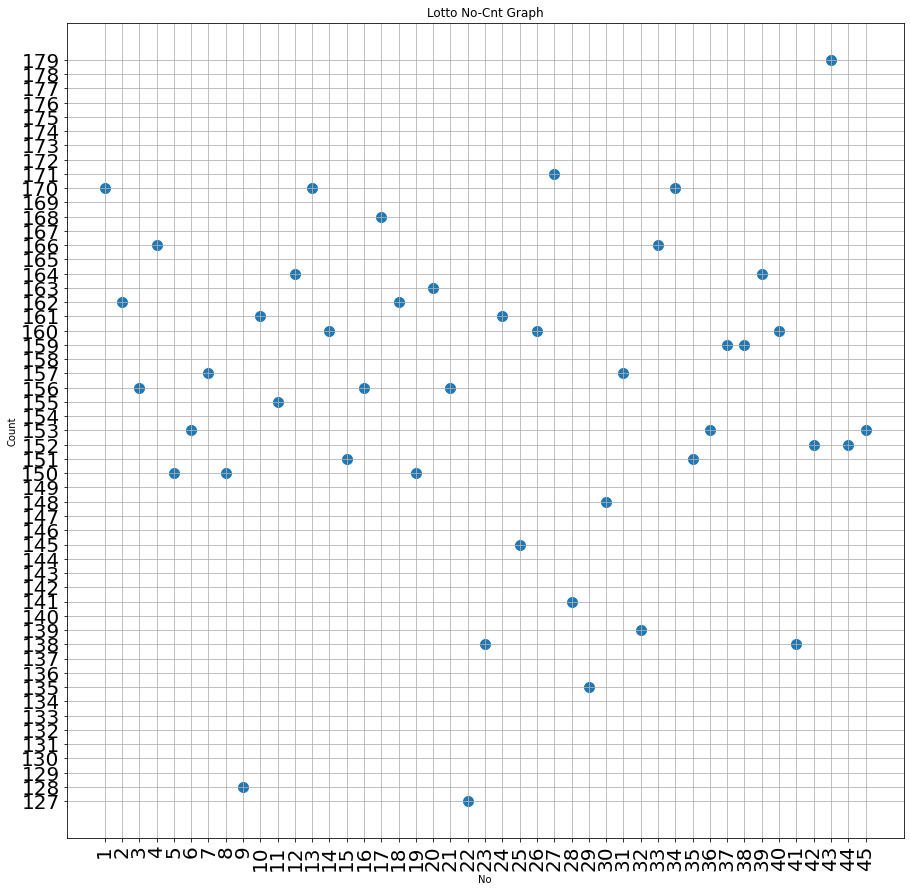

In [110]:
plt.title("Lotto No-Cnt Graph")
plt.xlabel("No")
plt.ylabel("Count")
plt.scatter([no[0] for no in df_listNo.value_counts().index], df_listNo.value_counts().values.tolist(), s=100)
plt.rcParams['figure.figsize'] = [15,15]
plt.xticks(range(1,46), rotation=90, size=20)
plt.yticks(range(min(df_listNo.value_counts().values.tolist()), max(df_listNo.value_counts().values.tolist())+1), size=20)
plt.grid()
plt.show()

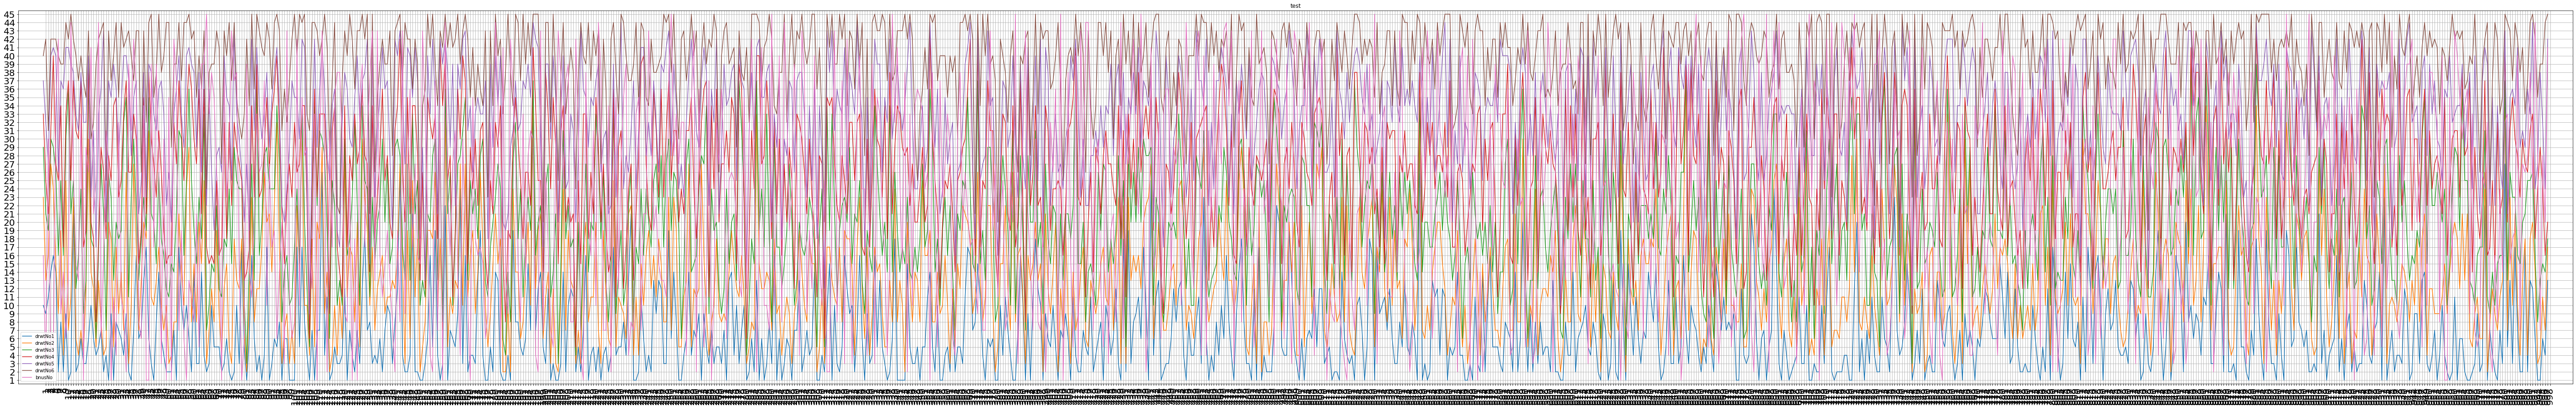

In [158]:
plt.title("test")
plt.plot(numbers.index.values.tolist(), numbers['drwtNo1'].values.tolist(), label='drwtNo1')
plt.plot(numbers.index.values.tolist(), numbers['drwtNo2'].values.tolist(), label='drwtNo2')
plt.plot(numbers.index.values.tolist(), numbers['drwtNo3'].values.tolist(), label='drwtNo3')
plt.plot(numbers.index.values.tolist(), numbers['drwtNo4'].values.tolist(), label='drwtNo4')
plt.plot(numbers.index.values.tolist(), numbers['drwtNo5'].values.tolist(), label='drwtNo5')
plt.plot(numbers.index.values.tolist(), numbers['drwtNo6'].values.tolist(), label='drwtNo6')
plt.plot(numbers.index.values.tolist(), numbers['bnusNo'].values.tolist() , label='bnusNo')
plt.yticks(range(1,46), size=20)
plt.xticks(range(1,999), rotation=90, size=20)
plt.rcParams["figure.figsize"] = [100,15]
plt.grid()
plt.legend()
plt.margins(x=0.01, y=0.01)
plt.show()

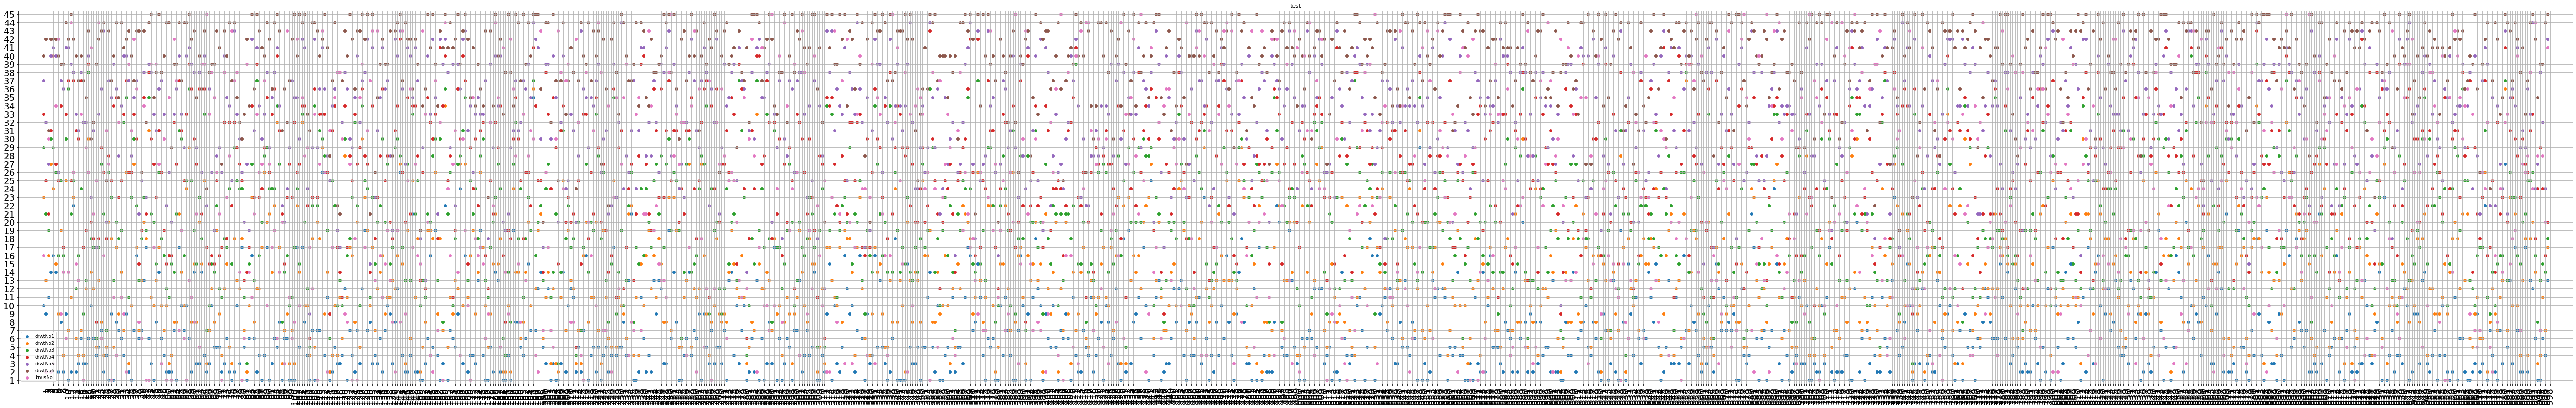

In [159]:
plt.title("test")
plt.scatter(numbers.index.values.tolist(), numbers['drwtNo1'].values.tolist(), label='drwtNo1')
plt.scatter(numbers.index.values.tolist(), numbers['drwtNo2'].values.tolist(), label='drwtNo2')
plt.scatter(numbers.index.values.tolist(), numbers['drwtNo3'].values.tolist(), label='drwtNo3')
plt.scatter(numbers.index.values.tolist(), numbers['drwtNo4'].values.tolist(), label='drwtNo4')
plt.scatter(numbers.index.values.tolist(), numbers['drwtNo5'].values.tolist(), label='drwtNo5')
plt.scatter(numbers.index.values.tolist(), numbers['drwtNo6'].values.tolist(), label='drwtNo6')
plt.scatter(numbers.index.values.tolist(), numbers['bnusNo'].values.tolist() , label='bnusNo')
plt.yticks(range(1,46), size=20)
plt.xticks(range(1,999), rotation=90, size=20)
plt.rcParams["figure.figsize"] = [100,15]
plt.grid()
plt.legend()
plt.margins(x=0.01, y=0.01)
plt.show()

In [ ]:
plt.title("Lotto No-Cnt Graph")
plt.xlabel("No")
plt.ylabel("Count")
plt.scatter([no[0] for no in df_listNo.value_counts().index], df_listNo.value_counts().values.tolist(), s=100)
plt.rcParams['figure.figsize'] = [15,15]
plt.xticks(range(1,46), rotation=90, size=20)
plt.yticks(range(min(df_listNo.value_counts().values.tolist()), max(df_listNo.value_counts().values.tolist())+1), size=20)
plt.grid()
plt.show()

([<matplotlib.patches.Wedge at 0x2c4e272e0>,
 [Text(1.0964381403975176, 0.08845001007141484, '43'),
  Text(1.0690209918143085, 0.2592182845795267, '27'),
  Text(1.016881631845553, 0.4194660258174974, '34'),
  Text(0.9411329487244763, 0.5694460227494546, '13'),
  Text(0.8434256408278544, 0.7061396380278644, '1'),
  Text(0.7267823556163572, 0.8257041888986267, '17'),
  Text(0.5950453599376346, 0.9251599967663383, '33'),
  Text(0.4508120873506595, 1.003378523737947, '4'),
  Text(0.29750125086168955, 1.059005668415297, '39'),
  Text(0.13863215375908092, 1.0912291812191053, '12'),
  Text(-0.022753081321082013, 1.0997646554106004, '20'),
  Text(-0.18267166276387636, 1.084726262069413, '18'),
  Text(-0.33822457281428503, 1.046711105484505, '2'),
  Text(-0.4861662763467141, 0.9867331715023928, '10'),
  Text(-0.6234612403979851, 0.9062538726656046, '24'),
  Text(-0.747343478213524, 0.8071417010486525, '26'),
  Text(-0.855368779328788, 0.6916243571112713, '40'),
  Text(-0.9457114711691696, 0.561

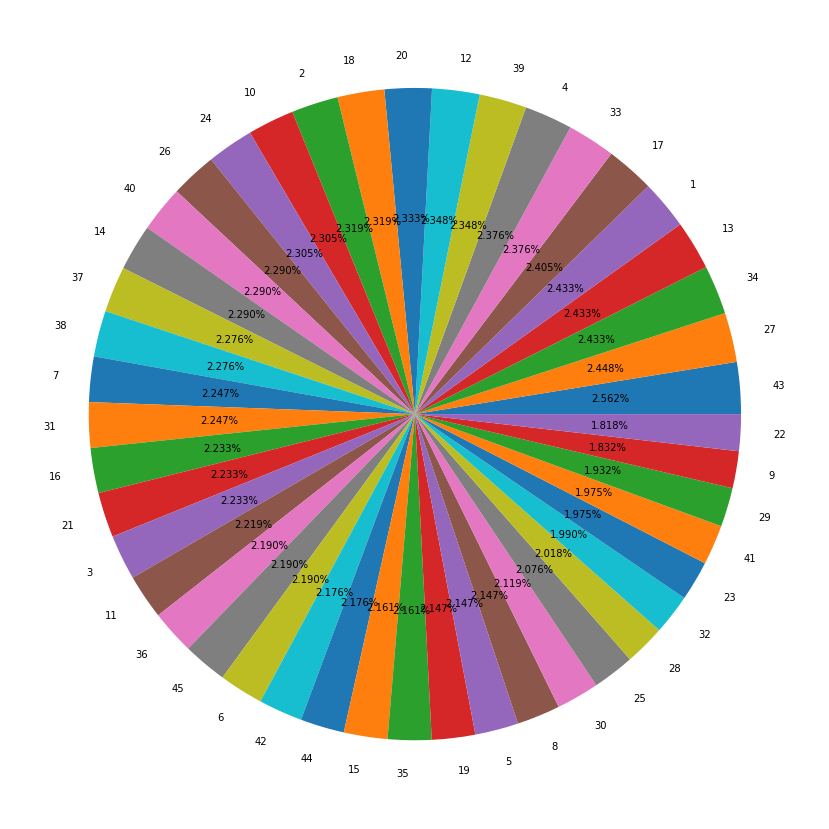

In [165]:
cnt = df_listNo.value_counts().values.tolist()
no = [no[0] for no in df_listNo.value_counts().index]
plt.pie(cnt, labels=no, autopct='%.3f%%')
# plt.show()